# Intuit Quickbooks Upgrade

* Team-lead GitLab userid:
* Group name:
* Team member names:

## Setup

Please complete this python notebook with your group by answering the questions in `intuit-redux.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the second group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `model1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - model1.ipynb, model2.ipynb, model3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import xgboost as xgb
from sklearn import metrics
from pyrsm import profit_max, confusion, profit_plot, gains_plot, lift_plot, ROME_plot
from sklearn.model_selection import RandomizedSearchCV


In [2]:
 mpl.rcParams["figure.dpi"] = 250

In [5]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [6]:
# show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-

## Gradient Boosted Trees

### Data Cleaning

In [7]:
intuit75k.zip_bins = intuit75k.zip_bins.astype(object)

In [8]:
intuit75k = intuit75k.join(pd.get_dummies(intuit75k.zip_bins), how='inner')

In [9]:
intuit75k = intuit75k.assign(

    zip801 = (intuit75k['zip'] == '00801').astype(int),
    zip804 = (intuit75k['zip'] == '00804').astype(int)
)

In [10]:
intuit75k.dtypes

id               int32
zip             object
zip_bins        object
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
1                uint8
2                uint8
3                uint8
4                uint8
5                uint8
6                uint8
7                uint8
8                uint8
9                uint8
10               uint8
11               uint8
12               uint8
13               uint8
14               uint8
15               uint8
16               uint8
17               uint8
18               uint8
19               uint8
20               uint8
zip801           int64
zip804           int64
dtype: object

In [11]:
intuit_train = intuit75k.query('training == 1').reset_index()
intuit_val = intuit75k.query('training == 0').reset_index()

In [12]:
X_train = intuit_train.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index','bizflag'])
y_train = intuit_train[['res1_yes']]
X_test = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index','bizflag'])
y_test = intuit_val[['res1_yes']]

### Fitting the XGBoost Model

In [13]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=123, max_depth=2,n_jobs=6, use_label_encoder=False,reg_lambda=3.9, learning_rate=0.3)
xgb_clf.fit(X_train, y_train.values.ravel(), early_stopping_rounds=100, eval_metric="auc", verbose=True, eval_set=[(X_test, y_test.values.ravel())])

[0]	validation_0-auc:0.66263
[1]	validation_0-auc:0.70723
[2]	validation_0-auc:0.72689
[3]	validation_0-auc:0.72222
[4]	validation_0-auc:0.73195
[5]	validation_0-auc:0.72766
[6]	validation_0-auc:0.72994
[7]	validation_0-auc:0.73743
[8]	validation_0-auc:0.74284
[9]	validation_0-auc:0.75380
[10]	validation_0-auc:0.75251
[11]	validation_0-auc:0.75479
[12]	validation_0-auc:0.75472
[13]	validation_0-auc:0.75820
[14]	validation_0-auc:0.75831
[15]	validation_0-auc:0.76084
[16]	validation_0-auc:0.76181
[17]	validation_0-auc:0.76300
[18]	validation_0-auc:0.76291
[19]	validation_0-auc:0.76288
[20]	validation_0-auc:0.76344
[21]	validation_0-auc:0.76455
[22]	validation_0-auc:0.76529
[23]	validation_0-auc:0.76595
[24]	validation_0-auc:0.76637
[25]	validation_0-auc:0.76593
[26]	validation_0-auc:0.76558
[27]	validation_0-auc:0.76594
[28]	validation_0-auc:0.76618
[29]	validation_0-auc:0.76639
[30]	validation_0-auc:0.76636
[31]	validation_0-auc:0.76620
[32]	validation_0-auc:0.76634
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=6, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=3.9, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
# Prediction probabilities on the test set
pred = xgb_clf.predict_proba(X_test)
probs = pd.Series([p[1] for p in pred])

# Prediction probabilities on the train set
pred_train = xgb_clf.predict_proba(X_train)
probs_train = pd.Series([p[1] for p in pred_train])

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.7675955115423396


In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.7827163935059891


In [17]:
breakeven = 1.41/30

In [18]:
pred_prof = pd.Series((probs)) 
pred_prof.name = 'predictions_xgb_1_test'

pred_prof_train = pd.Series((probs_train))
pred_prof_train.name = 'predictions_xgb_1_train'

df_test = y_test.join(pred_prof, how='inner')

In [19]:
p = profit_max(df_test,'res1_yes',1,'predictions_xgb_1_test',1.41,30)

print(f'The profit for {xgb_clf} on the test data is ${round(p,3)}')

The profit for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=6, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=3.9, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None) on the test data is $13618.65


In [20]:
TP, FP, TN, FN, contact = confusion(df_test,'res1_yes',1,'predictions_xgb_1_test',1.41,30)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 747
TN: 15909
FP: 5488
FN: 356


In [21]:
df_test['target_xgb'] = (df_test.predictions_xgb_1_test > breakeven).astype(int)

total_biz = 801821
already_resp = 38487
population = total_biz - already_resp
response_rate_xgb = np.mean(df_test[df_test.target_xgb == 1]['res1_yes'])
targets = population * contact
responses = targets * (response_rate_xgb/2)

In [22]:
cost = targets * 1.41
rev = responses * 60
profit = rev - cost
print(f'The projected profit for the those people who did not respond to wave 1 of mailing but will be mailed a second time is $ {round(profit,2)}')

The projected profit for the those people who did not respond to wave 1 of mailing but will be mailed a second time is $ 462025.71


### Decision Tree Plot

<AxesSubplot:>

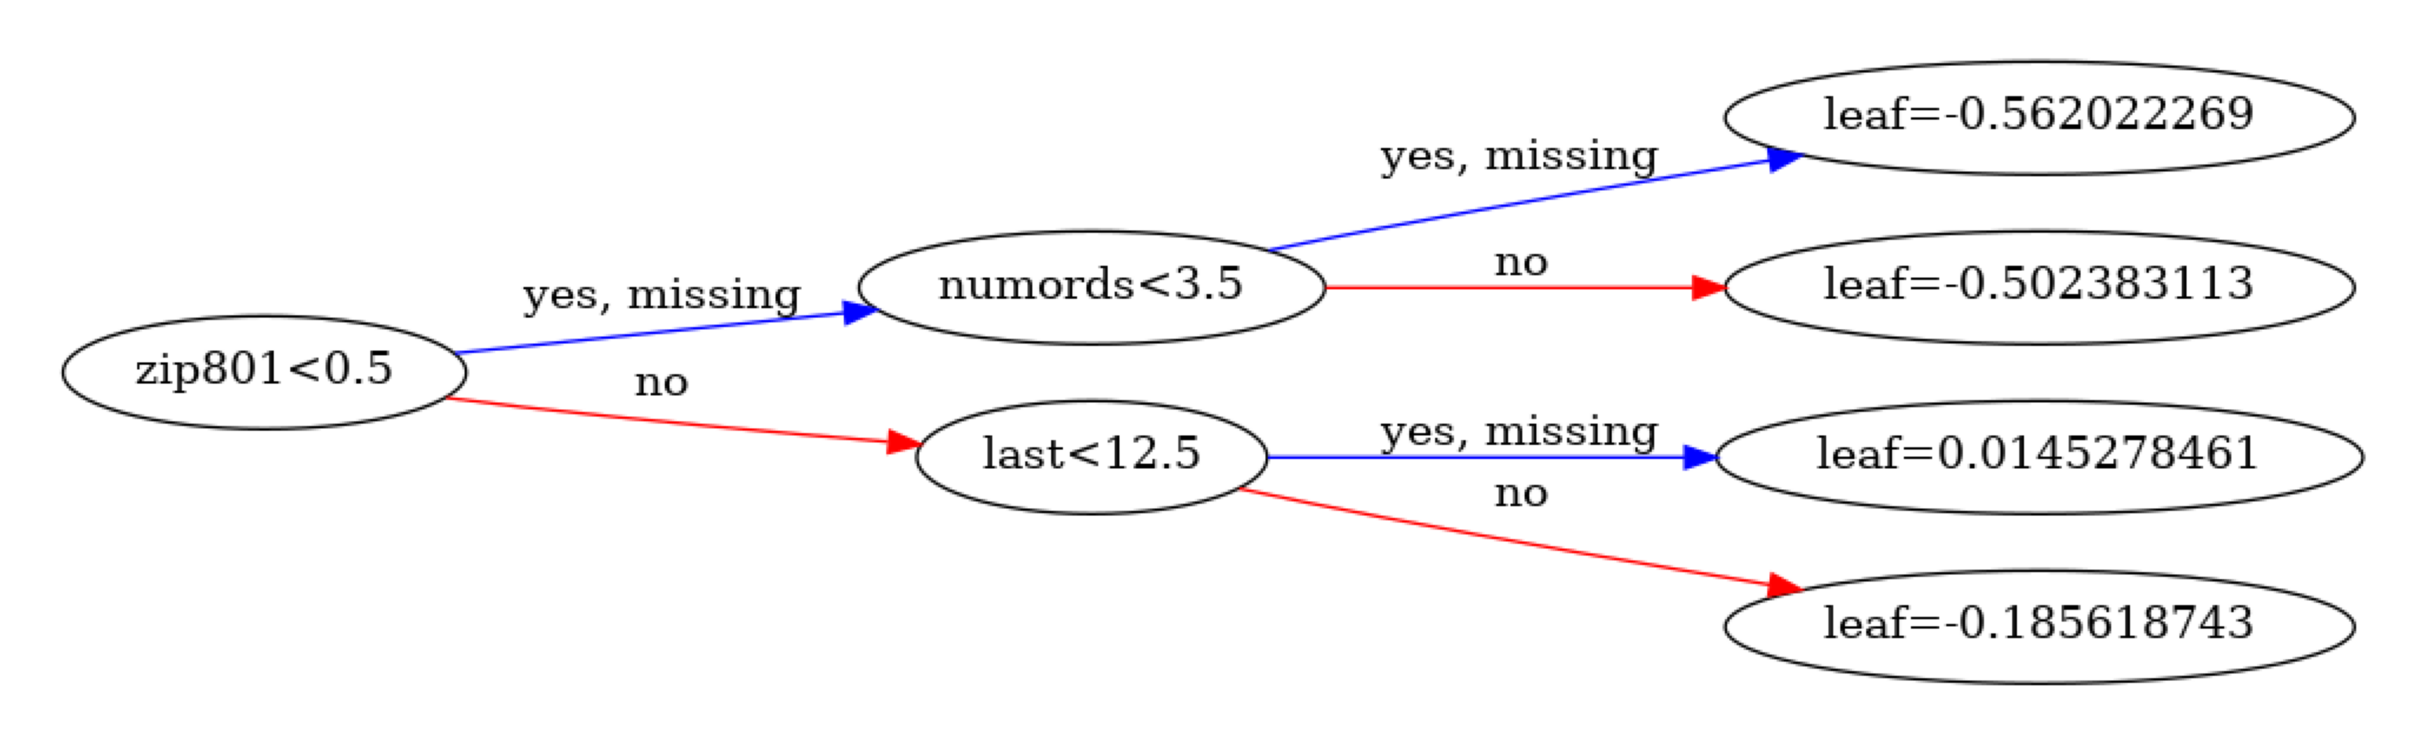

In [22]:
mpl.rcParams["figure.dpi"] = 500
xgb.plot_tree(xgb_clf, rankdir='LR')

### Randomised Search Cross-validation

In [11]:
clf = xgb.XGBClassifier(objective='binary:logistic',seed=123, use_label_encoder=False)

In [107]:
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : "auc", 
            "eval_set" : [(X_test, y_test.values.ravel())]}

In [108]:
gbm_param_grid = {
    'learning_rate': np.arange(0.1, 0.3, 0.05),
    'max_depth': np.arange(1, 4, 1),
    'n_estimators': 1000,
    'reg_lambda':np.arange(3,5,1)
}

In [109]:
from sklearn.metrics import make_scorer

def profit_scoring(y_true, y_pred):
    profit = rsm.profit(pd.Series(y_true), pd.Series(y_pred), 1, 1.41, 30)
    return profit

profit_score = make_scorer(profit_scoring, greater_is_better = True, needs_proba=True)

In [110]:
randomized_roc_auc = RandomizedSearchCV(scoring=profit_score,verbose=1, estimator=clf, param_distributions=gbm_param_grid, n_jobs=6)
randomized_roc_auc.fit(X_train,y_train.values.ravel(),**fit_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-auc:0.67453
[1]	validation_0-auc:0.74596
[2]	validation_0-auc:0.74563
[3]	validation_0-auc:0.74729
[4]	validation_0-auc:0.74921
[5]	validation_0-auc:0.74682
[6]	validation_0-auc:0.74731
[7]	validation_0-auc:0.74853
[8]	validation_0-auc:0.74918
[9]	validation_0-auc:0.74898
[10]	validation_0-auc:0.75153
[11]	validation_0-auc:0.75276
[12]	validation_0-auc:0.75376
[13]	validation_0-auc:0.75977
[14]	validation_0-auc:0.76063
[15]	validation_0-auc:0.76198
[16]	validation_0-auc:0.76276
[17]	validation_0-auc:0.76316
[18]	validation_0-auc:0.76377
[19]	validation_0-auc:0.76444
[20]	validation_0-auc:0.76494
[21]	validation_0-auc:0.76529
[22]	validation_0-auc:0.76458
[23]	validation_0-auc:0.76453
[24]	validation_0-auc:0.76454
[25]	validation_0-auc:0.76469
[26]	validation_0-auc:0.76486
[27]	validation_0-auc:0.76517
[28]	validation_0-auc:0.76513
[29]	validation_0-auc:0.76508
[30]	validation_0-auc:0.76534
[31]	validation_0-a

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                           validate_par

In [23]:
df_test

,res1_yes,predictions_xgb_1_test,target_xgb
0,0,0.028346,0
1,0,0.075152,1
2,0,0.024862,0
3,0,0.025639,0
4,0,0.017403,0
...,...,...,...
22495,0,0.032376,0
22496,0,0.016093,0
22497,0,0.121897,1
22498,1,0.146067,1
